In [1]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import math as mth

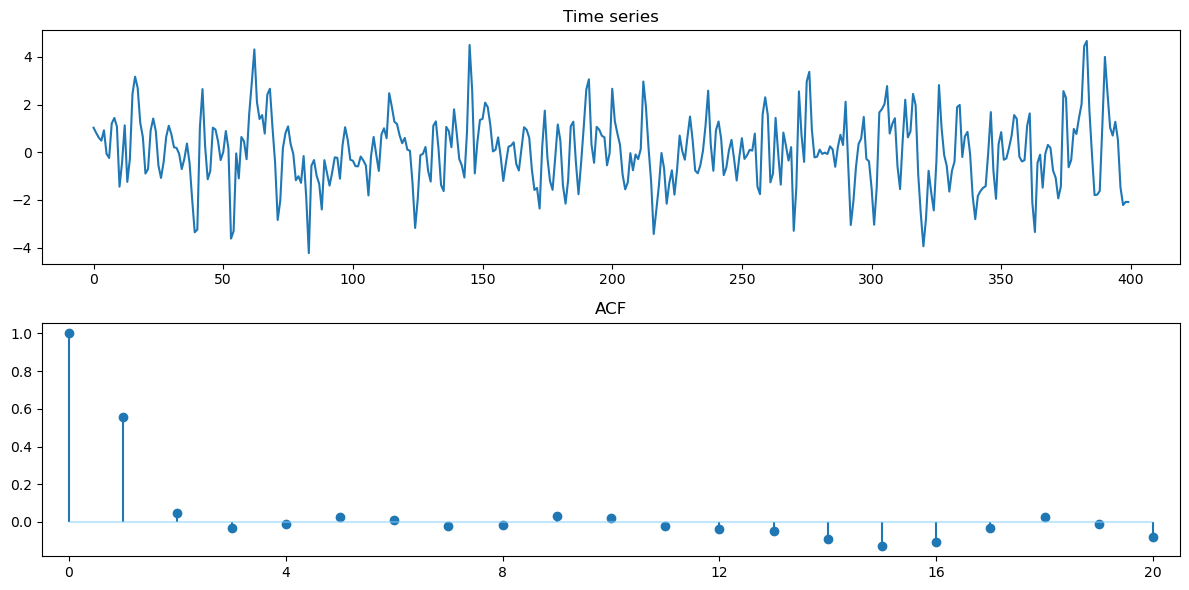

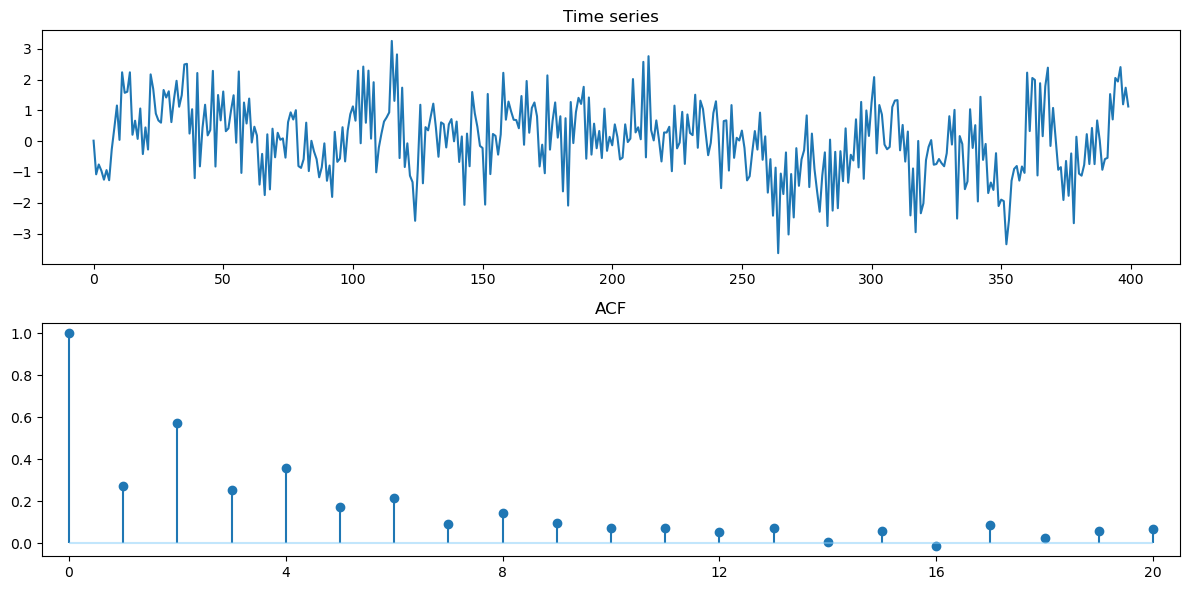

In [2]:
# (2.2.6)

def plot_ts_acf(X, nlags = 20, figsize = (12, 6)):

    fig, axes = plt.subplots(2, 1, figsize = figsize)
    x = range(nlags + 1)
    acf = sm.tsa.acf(X, nlags = nlags)
    titles = ["Time series", "ACF"]

    axes[0].plot(range(len(X)), X)
    axes[1].scatter(x, acf)
    axes[1].vlines(x, 0, acf, color = "tab:blue")
    axes[1].hlines(0, 0, nlags, color = "lightskyblue", alpha  =0.5)
    axes[1].set_xlim(-0.5, nlags + 0.5)
    axes[1].set_xticks([i * 4 for i in range(mth.floor(nlags/4) + 1)])
    for (i, ax) in enumerate(axes):
        ax.set_title(titles[i])
    fig.tight_layout()
    plt.show()

# Only (a) and (b) are causal. 
np.random.seed(457334)

arma = sm.tsa.ArmaProcess(ar = [1.0, -0.1], ma = [1.0, 0.9])
X = arma.generate_sample(nsample = 800)
plot_ts_acf(X[400:])

arma = sm.tsa.ArmaProcess(ar = [1.0, -0.2, -0.5], ma = [1.0])
X = arma.generate_sample(nsample = 800)
plot_ts_acf(X[400:])

In [202]:
# (2.3.7)

# D-L

def DL(acvf, n):
    if len(acvf) <= n:
        raise ValueError("Length of acvf must exceed n")
    
    Lambda = np.zeros((n, n))
    nu = np.zeros(n+1)

    nu[0] = acvf[0]
    Lambda[0, 0] = acvf[1] / acvf[0]
    nu[1] = (1 - Lambda[0,0]**2) * nu[0]

    for i in range(1, n): 
        Lambda[i, i] = (acvf[i+1] - np.dot(Lambda[i - 1, 0:i], acvf[1:(i+1)][::-1]) ) / nu[i]
        nu[i+1] = nu[i] * (1 - Lambda[i,i]**2)
        Lambda[i, 0:i] = Lambda[i-1, 0:i] - Lambda[i,i] * Lambda[i-1, 0:i][::-1]

    return Lambda, nu

# Generate kappa matrix for arma
def kappa_arma(phi, theta, gamma_X):
    n = len(gamma_X)
    q = len(theta)
    p = len(phi)
    m = max(p, q)
    kappa = np.zeros((n, n))
    for i in range(n):
        for j in range(i+1):
            if (i+1 <= m) and (j+1 <= m):
                kappa[i, j] = gamma_X[abs(i-j)]
            elif min(i+1, j+1) <= m < max(i+1, j+1) <= 2*m:
                kappa[i, j] = gamma_X[abs(i-j)]
                for r in range(1, p+1):
                    kappa[i, j] += phi[r-1] * gamma_X[abs(r - abs(i-j))]  # + to keep in accordance with the phi in sm.tsa.ArmaProcess
            elif min(i+1, j+1) > m:
                if i - j == 0:
                    kappa[i, j] = 1.0
                elif abs(i-j) - 1 < q:
                    kappa[i, j] = theta[abs(i-j) - 1]
                for r in range(q):
                    if r + abs(i-j) < q:
                        kappa[i, j] += theta[r] * theta[r + abs(i-j)]
    return kappa + kappa.T - np.diag(np.diag(kappa)) 

# Innovations with kappa matrix

def innov(kappa, n):
    if kappa.shape[0] != kappa.shape[1]:
        raise ValueError("kappa must be a square matrix")

    if kappa.shape[0] <= n:
        raise ValueError("kappa must have dimension at least n")

    Theta = np.zeros((n, n))
    nu = np.zeros(n+1)

    nu[0] = kappa[0, 0]
    Theta[0, 0] = kappa[1, 0] / nu[0]
    nu[1] = kappa[1, 1] - Theta[0,0]**2 * nu[0]

    for i in range(1, n):
        Theta[i, i] = kappa[i + 1, 0] / nu[0]
        for k in range(1, i+1):
            Theta[i, i - k] = (kappa[i + 1, k] - np.sum(Theta[k-1, 0:k] * Theta[i, i-k+1:i+1] * nu[0:k][::-1])) / nu[k]
        nu[i+1] = kappa[i+1,i+1] - np.sum(Theta[i, 0:i+1]**2 * nu[0:i+1][::-1])

    return Theta, nu

# AR(2)

ar2 = sm.tsa.ArmaProcess(ar = [1.0, -0.4, -0.2])
print(DL(ar2.acf(5), 4))
print("\n")

# MA(1)
ma1 = sm.tsa.ArmaProcess(ma = [1.0, 0.9])
acvf = ma1.acovf(10)
innov(kappa_arma([], [0.9], ma1.acovf(5+1)), 5)

(array([[5.00000000e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.00000000e-01, 2.00000000e-01, 0.00000000e+00, 0.00000000e+00],
       [4.00000000e-01, 2.00000000e-01, 7.70988212e-17, 0.00000000e+00],
       [4.00000000e-01, 2.00000000e-01, 7.70988212e-17, 0.00000000e+00]]), array([1.  , 0.75, 0.72, 0.72, 0.72]))




(array([[0.49723757, 0.        , 0.        , 0.        , 0.        ],
        [0.66055716, 0.        , 0.        , 0.        , 0.        ],
        [0.74043691, 0.        , 0.        , 0.        , 0.        ],
        [0.78698379, 0.        , 0.        , 0.        , 0.        ],
        [0.81690849, 0.        , 0.        , 0.        , 0.        ]]),
 array([1.81      , 1.36248619, 1.21549856, 1.14360678, 1.10171459,
        1.07478236]))

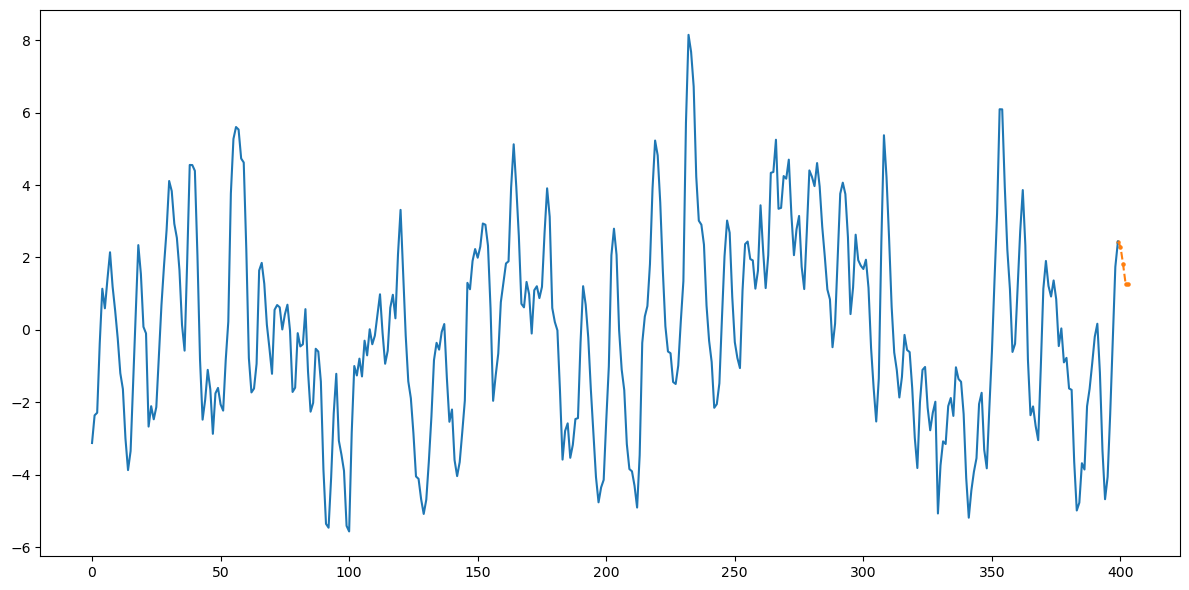

In [333]:
# (2.3.8)
np.random.seed(8453045)

phi = [-1, 0.24]
theta = [0.4, 0.2, 0.1]
p = len(phi)
q = len(theta)
m = max(p, q)

n = 400
burn_in = 400
H = 4

arma = sm.tsa.ArmaProcess(ar = [1.0] + phi, ma = [1.0] + theta)
Xhat = np.zeros(n + H)
Theta, nu = innov(kappa_arma(phi, theta, arma.acovf(n+H+1)), n+H)

X = arma.generate_sample(nsample = n + burn_in)[burn_in:]

for i in range(1, m):
    Xhat[i] = np.dot(Theta[i-1, 0:i][::-1], X[0:i] - Xhat[0:i])

for i in range(m, n+1):
    Xhat[i] = -np.dot(phi[::-1], X[i-p:i]) + np.dot(Theta[i-1, 0:q][::-1], X[i-q:i] - Xhat[i-q:i])

for i in range(1, H):
    # This starts at h=2 due to zero-indexing
    j = p - i 
    if j > 0:
        Xhat[n+i] = -np.dot(phi[::-1][0:j], X[n-j:n]) - np.dot(phi[::-1][j:], Xhat[n:n+(p-j)])
    else:
        Xhat[n+i] = -np.dot(phi[::-1], Xhat[n:n+p])
    Xhat[n + i] += np.dot(Theta[n + i-1, i:q][::-1], X[n+i-q:n] - Xhat[n+i-q:n])


fig, ax = plt.subplots(figsize = (12, 6))
ax.plot(X)
ax.scatter(range(n-1,n+H), np.concatenate((X[n-2:n][1:], Xhat[n:])), color = "tab:orange", s = 5.0)
ax.plot(range(n-1,n+H), np.concatenate((X[n-2:n][1:], Xhat[n:])), color = "tab:orange", linestyle = "--")

fig.tight_layout()
plt.show()